In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found 3910 images belonging to 2 classes.
Found 976 images belonging to 2 classes.
Epoch 1/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 76s 551ms/step - accuracy: 0.6048 - loss: 1.0988 - val_accuracy: 0.5338 - val_loss: 0.7927 - learning_rate: 1.0000e-04
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 68s 527ms/step - accuracy: 0.6839 - loss: 0.7242 - val_accuracy: 0.4887 - val_loss: 1.4002 - learning_rate: 1.0000e-04
Epoch 3/30
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.7254 - loss: 0.6520
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
123/123 ━━━━━━━━━━━━━━━━━━━━ 68s 530ms/step - accuracy: 0.7254 - loss: 0.6520 - val_accuracy: 0.4836 - val_loss: 1.7197 - learning_rate: 1.0000e-04
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 68s 527ms/step - accuracy: 0.7540 - loss: 0.5636 - val_accuracy: 0.4887 - val_loss: 2.0258 - learning_rate: 5.0000e-05
Epoch 5/30
122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7898 - loss: 0.5192
Epoch 5: ReduceLROnPlateau reducing lear

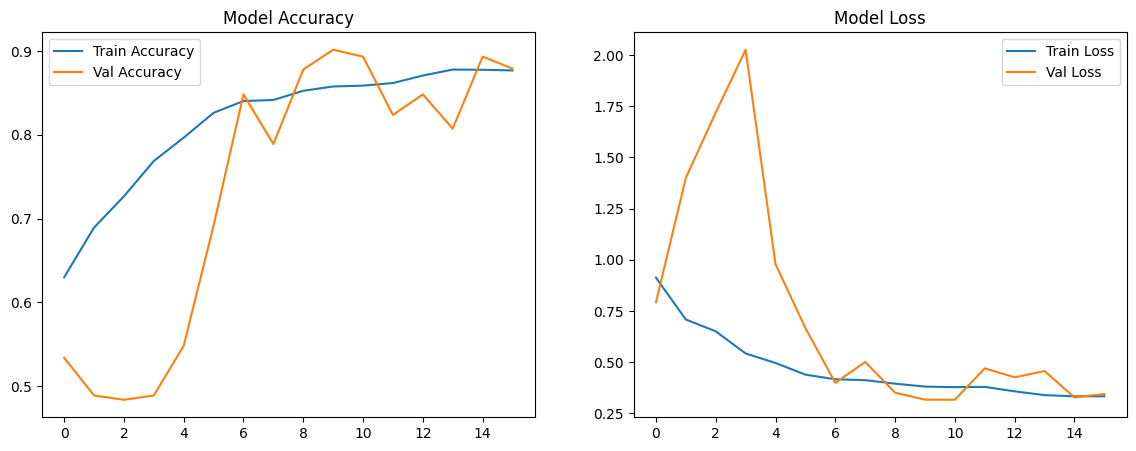


✅ Final Validation Accuracy: 0.88


In [7]:
import tensorflow as tf #2nd time improvement of that lenet - the updated model code with batchnorm + augmentation
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Dataset Path
dataset_path = '/kaggle/input/steganography'

# Data Augmentation & Preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True  # enabled shuffling here too
)

# CNN Model with BatchNormalization
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4), input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Training
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[early_stop, lr_reduce]
)

# Plot Accuracy & Loss
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

# Final Validation Accuracy
val_acc = history.history['val_accuracy'][-1]
print(f"\n✅ Final Validation Accuracy: {val_acc:.2f}")


In [9]:
model.save('model_new_lenet_88_acc.keras')
print("model saved successfully")

model saved successfully


In [10]:
import os
os.listdir('/kaggle/working/')


['vgg16_stegano_model.h5',
 'model_new_lenet_88_acc.keras',
 '.virtual_documents']

In [17]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the model once
model = load_model('model_new_lenet_88_acc.keras')
print("✅ Model loaded successfully!")

# Define class labels
class_labels = ['lsb', 'non_stego']

# Define a function to predict an image
def predict_steganography(img_path):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    # Output
    print(f"\n🧠 Predicted Class: {class_labels[predicted_class]}")
    print(f"🔍 Confidence: {confidence:.2f}")

# Example usage
predict_steganography('/kaggle/input/steganography/lsb/image_00001_eth_0.png')

✅ Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step

🧠 Predicted Class: lsb
🔍 Confidence: 0.62


In [18]:
predict_steganography('/kaggle/input/steganography/non_stego/01366.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

🧠 Predicted Class: non_stego
🔍 Confidence: 1.00


In [19]:
predict_steganography('/kaggle/input/steganography/non_stego/01378.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

🧠 Predicted Class: non_stego
🔍 Confidence: 1.00


In [20]:
predict_steganography('/kaggle/input/steganography/non_stego/01393.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

🧠 Predicted Class: non_stego
🔍 Confidence: 1.00


In [21]:
predict_steganography('/kaggle/input/steganography/lsb/image_00002_eth_0.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

🧠 Predicted Class: lsb
🔍 Confidence: 0.97


In [4]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/steg_lenet/keras/default/1/model_new_lenet_88_acc (1).keras')
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/kaggle/input/steganography'  # update path if needed

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # ❗Important: disable shuffle for correct label alignment
)


Found 976 images belonging to 2 classes.


In [6]:
loss, acc = model.evaluate(val_gen, verbose=1)
print(f"\n📊 Validation Accuracy: {acc:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.9350 - loss: 0.2876

📊 Validation Accuracy: 0.94


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step


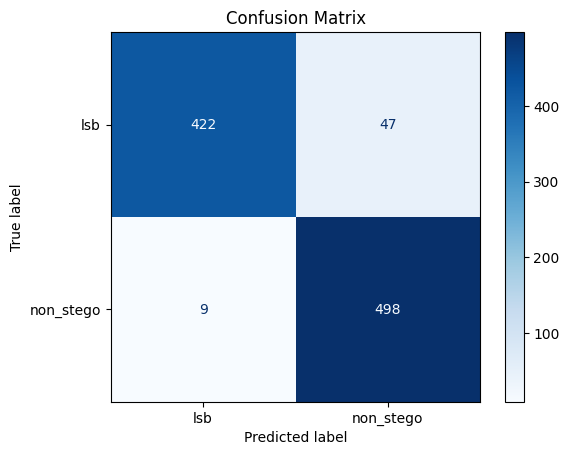


📋 Classification Report:

              precision    recall  f1-score   support

         lsb       0.98      0.90      0.94       469
   non_stego       0.91      0.98      0.95       507

    accuracy                           0.94       976
   macro avg       0.95      0.94      0.94       976
weighted avg       0.95      0.94      0.94       976



In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Predictions
pred_probs = model.predict(val_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\n📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


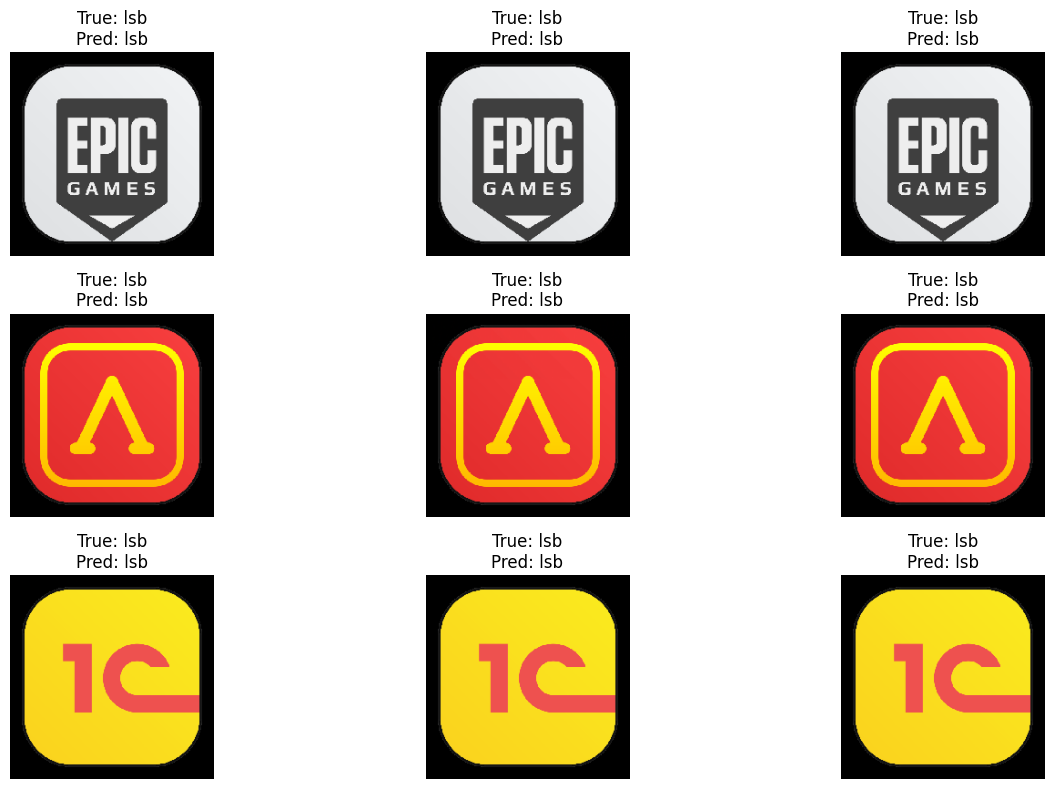

In [10]:
import matplotlib.pyplot as plt

val_gen.reset()
x_batch, y_batch = next(val_gen)
pred_batch = model.predict(x_batch)
pred_labels = np.argmax(pred_batch, axis=1)
true_labels = np.argmax(y_batch, axis=1)

plt.figure(figsize=(14, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
